In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, scf
import torch
import pickle
import numpy as np
from tqdm import tqdm
import os
import argparse
import torch
from rdkit import Chem
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from dgl.nn import SumPooling, AvgPooling
# from tensorboardX import SummaryWriter
from model.byol import BGRL
from model.edieggc import EDiGIN
from data.data import QM9Dataloader
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def calculate_mu_from_rdkitmol(mol):

    conf = mol.GetConformer()
    coords = torch.tensor([conf.GetAtomPosition(i) for i in range(mol.GetNumAtoms())])
    charges = [atom.GetFormalCharge() for atom in mol.GetAtoms()]

    # Create a pySCF Mole object from the atomic coordinates and charges
    mol_pyscf = gto.Mole()
    mol_pyscf.atom = '\n'.join(['{} {} {} {}'.format(a.GetSymbol(), x, y, z)
                                for a, (x, y, z) in zip(mol.GetAtoms(), coords)])
    mol_pyscf.charge = sum(charges)
    mol_pyscf.build()
    mol_pyscf.basis = '6-31g'

    # Set up the SCF calculation
    mf = mol_pyscf.KS()
    mf.xc = 'b3lyp'

    # run energy calculations
    mf.kernel()

    # Calculate the dipole moment
    dipole = mf.dip_moment()
    return dipole

In [23]:
mol = Chem.MolFromSmiles('CCCCCCO')
mol = Chem.AddHs(mol, 0)
AllChem.EmbedMolecule(mol)
mu = calculate_mu_from_rdkitmol(mol)


converged SCF energy = -308.174893009949
Dipole moment(X, Y, Z, Debye):  0.27449,  0.87960, -0.99696


CGCF domain의 test data label

In [18]:
with open('20230105_012900_mmff_lumo_g/history_mmff_lumo_g.pickle', 'rb') as f:
    history_mmff_lumo_g = pickle.load(f)
test_idx = history_mmff_lumo_g['test_indices']

In [19]:
with open('./qm9_all_cgcf.pkl', 'rb') as f:
    cgcfqm9 = pickle.load(f)

In [20]:
test_cgcfqm9 = [cgcfqm9[i] for i in test_idx]
len(test_cgcfqm9)

13855

In [21]:
cgcfqm9_label = [np.linalg.norm(calculate_mu_from_rdkitmol(mol)) for mol in tqdm(test_cgcfqm9[:30])]

  0%|          | 0/30 [00:00<?, ?it/s]

converged SCF energy = -379.505155328981
Dipole moment(X, Y, Z, Debye):  1.35141, -1.28069,  0.60702


  3%|▎         | 1/30 [00:43<20:59, 43.43s/it]

converged SCF energy = -388.854237948576
Dipole moment(X, Y, Z, Debye):  0.33122, -0.08983,  0.51131


  7%|▋         | 2/30 [02:26<36:33, 78.33s/it]

converged SCF energy = -431.790573846145
Dipole moment(X, Y, Z, Debye): -0.57082,  0.86753,  2.65339


 10%|█         | 3/30 [03:08<27:49, 61.85s/it]

converged SCF energy = -376.783194807082
Dipole moment(X, Y, Z, Debye):  1.13717, -3.94781,  0.54970


 13%|█▎        | 4/30 [04:28<29:54, 69.01s/it]

converged SCF energy = -430.438620625763
Dipole moment(X, Y, Z, Debye): -1.58235, -1.31672,  0.36553


 17%|█▋        | 5/30 [05:14<25:14, 60.58s/it]

converged SCF energy = -306.80576128803
Dipole moment(X, Y, Z, Debye):  0.75366,  0.55287, -0.18878


 20%|██        | 6/30 [05:51<21:09, 52.88s/it]

converged SCF energy = -427.954538570031
Dipole moment(X, Y, Z, Debye):  1.75004,  2.52064,  0.21806


 23%|██▎       | 7/30 [06:37<19:20, 50.44s/it]

converged SCF energy = -468.454536418917
Dipole moment(X, Y, Z, Debye): -0.62924, -0.53029, -0.32938


 27%|██▋       | 8/30 [07:17<17:19, 47.24s/it]

converged SCF energy = -468.336374004135
Dipole moment(X, Y, Z, Debye): -0.57311, -2.23281, -0.16820


 30%|███       | 9/30 [08:05<16:32, 47.27s/it]

converged SCF energy = -447.697766133325
Dipole moment(X, Y, Z, Debye):  0.60718, -2.88190, -1.24689


 33%|███▎      | 10/30 [08:45<15:04, 45.22s/it]

converged SCF energy = -395.246720258228
Dipole moment(X, Y, Z, Debye): -2.46044, -1.50763,  0.59589


 37%|███▋      | 11/30 [09:27<13:58, 44.15s/it]

converged SCF energy = -383.149533967446
Dipole moment(X, Y, Z, Debye): -0.59139, -0.69378,  0.93215


 40%|████      | 12/30 [10:17<13:45, 45.86s/it]

converged SCF energy = -381.000274629308
Dipole moment(X, Y, Z, Debye):  2.48181,  0.34310,  0.14568


 43%|████▎     | 13/30 [10:58<12:36, 44.50s/it]

converged SCF energy = -452.498307427953
Dipole moment(X, Y, Z, Debye):  1.64040, -0.98577, -0.64747


 47%|████▋     | 14/30 [11:55<12:52, 48.31s/it]

converged SCF energy = -397.695064940422
Dipole moment(X, Y, Z, Debye): -2.89023, -1.57007, -0.93881


 50%|█████     | 15/30 [12:45<12:09, 48.64s/it]

converged SCF energy = -378.359921737574
Dipole moment(X, Y, Z, Debye): -0.92086, -0.09069,  2.50567


 53%|█████▎    | 16/30 [13:28<10:57, 46.93s/it]

converged SCF energy = -427.822562943322
Dipole moment(X, Y, Z, Debye): -1.74654,  1.22440,  4.24328


 57%|█████▋    | 17/30 [14:18<10:22, 47.90s/it]

converged SCF energy = -453.801270428952
Dipole moment(X, Y, Z, Debye): -0.34832, -0.77931,  3.07814


 60%|██████    | 18/30 [15:01<09:19, 46.61s/it]

converged SCF energy = -429.44638836879
Dipole moment(X, Y, Z, Debye):  0.86332,  0.39193,  2.10541


 63%|██████▎   | 19/30 [15:35<07:50, 42.79s/it]

converged SCF energy = -346.385915450769
Dipole moment(X, Y, Z, Debye):  0.24639,  0.06624, -0.07811


 67%|██████▋   | 20/30 [16:26<07:31, 45.13s/it]

converged SCF energy = -356.528999425956
Dipole moment(X, Y, Z, Debye): -0.35447, -1.23238,  0.11767


 70%|███████   | 21/30 [17:01<06:20, 42.25s/it]

converged SCF energy = -417.178030298989
Dipole moment(X, Y, Z, Debye):  1.09371, -1.02318, -0.94000


 73%|███████▎  | 22/30 [17:46<05:44, 43.10s/it]

converged SCF energy = -397.600922577867
Dipole moment(X, Y, Z, Debye): -0.41550,  0.13653,  0.37800


 77%|███████▋  | 23/30 [18:32<05:06, 43.73s/it]

converged SCF energy = -454.997131296342
Dipole moment(X, Y, Z, Debye):  1.19984,  0.72374,  0.40404


 80%|████████  | 24/30 [19:23<04:35, 45.91s/it]

converged SCF energy = -452.535919877766
Dipole moment(X, Y, Z, Debye):  0.42221,  0.01847,  0.05513


 83%|████████▎ | 25/30 [20:05<03:44, 44.98s/it]

converged SCF energy = -408.42906230594
Dipole moment(X, Y, Z, Debye): -0.30913,  3.96999,  1.22555


 87%|████████▋ | 26/30 [21:03<03:14, 48.71s/it]

SCF not converged.
SCF energy = -374.91460658765
Dipole moment(X, Y, Z, Debye): -7.95529,  1.45535,  2.49980


 90%|█████████ | 27/30 [23:35<03:58, 79.63s/it]

converged SCF energy = -430.283238062366
Dipole moment(X, Y, Z, Debye): -1.23142,  0.42767,  1.17555


 93%|█████████▎| 28/30 [24:21<02:19, 69.61s/it]

converged SCF energy = -417.125544683465
Dipole moment(X, Y, Z, Debye): -0.22953, -2.06219,  2.03076


 97%|█████████▋| 29/30 [25:05<01:02, 62.05s/it]

converged SCF energy = -397.776444557363
Dipole moment(X, Y, Z, Debye): -0.12562, -0.88913,  3.28529


100%|██████████| 30/30 [25:55<00:00, 51.86s/it]


In [11]:
from data.data import CGCFQM9Dataset
cgcfqm9dataset = CGCFQM9Dataset(num=133855, cutoff=5.0, target='mu', num_workers=7)
dft_label = [cgcfqm9dataset[i][-1] for i in test_idx]
with open('./test_dft_mu_label.pkl', 'wb') as f:
    pickle.dump(dft_label, f)

100%|██████████| 133855/133855 [03:00<00:00, 741.82it/s]


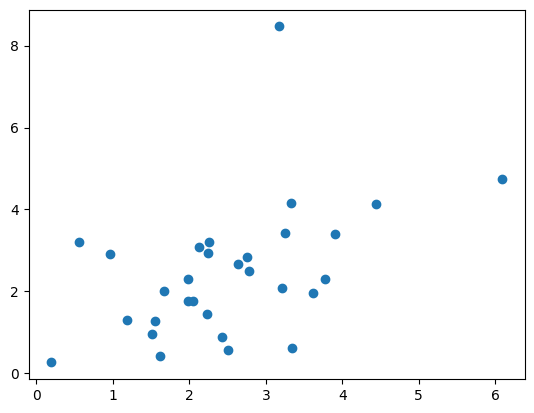

In [16]:
import matplotlib.pyplot as plt

plt.scatter(dft_label[:30], cgcfqm9_label)
plt.show()

In [16]:
parser = argparse.ArgumentParser(description='dipole moment prediction training')
"""Experiment setting."""
parser.add_argument('--exp-name', type=str, default='print_embeddings', help="dipole moment")
parser.add_argument('--pretrain', type=bool, default=False, help="dipole moment")
parser.add_argument('--num-workers', type=int, default=6, help="dipole moment")
parser.add_argument('--model-name', type=str, default='painn', help="dipole moment")
parser.add_argument('--dataset', type=str, default='QM9', help="data-chemical")
parser.add_argument('--set', type=str, default='g', help="train set for fine tuning")
parser.add_argument('--target', type=str, default='mu', help="dipole moment")
parser.add_argument('--geometry', type=str, default='CGCF', help="dipole moment")
parser.add_argument('--epochs', type=int, default=500, help="maximal training epoches")
parser.add_argument('--num-train', type=int, default=110000, help="maximal training epoches")
parser.add_argument('--num-valid', type=int, default=10000, help="maximal training epoches")
parser.add_argument('--num-test', type=int, default=13855, help="maximal training epoches")
parser.add_argument('--batch-size', type=int, default=64, help="maximal training epoches")
parser.add_argument('--learning-rate', type=float, default=1e-3, help="maximal training epoches")
parser.add_argument('--weight-decay', type=float, default=0, help="maximal training epoches")
parser.add_argument('--max-norm', type=float, default=1000.0, help="maximal training epoches")
parser.add_argument('--scheduler', type=str, default='plateau', help="maximal training epoches")
parser.add_argument('--cutoff', type=float, default=5.0, help="maximal training epoches")
parser.add_argument('--device', type=str, default='cuda:3', help="cuda device")
'''Model setting'''
parser.add_argument('--embedding-type', type=str, default='cgcnn', help="")
parser.add_argument('--alignn-layers', type=int, default=4, help="")
parser.add_argument('--gcn-layers', type=int, default=4, help="")
parser.add_argument('--atom-input-features', type=int, default=92, help="")
parser.add_argument('--edge-input-features', type=int, default=80, help="")
parser.add_argument('--triplet-input-features', type=int, default=40, help="")
parser.add_argument('--embedding-features', type=int, default=64, help="")
parser.add_argument('--hidden-features', type=int, default=256, help="painn:128, alignn:256")
parser.add_argument('--output-features', type=int, default=1, help="")
parser.add_argument('--classification', type=bool, default=False, help="")
parser.add_argument('--link', type=str, default='identity', help="")
args = parser.parse_args(args=[])


In [17]:
def return_prediction(model_b, model_g):
    train_loader, valid_loader, test_loader, test_indices = QM9Dataloader(args)
    del train_loader, valid_loader
    bgrl_trained_model = BGRL(args).to(args.device)
    # Change relative path of saved model
    bgrl_trained_model.load_state_dict(torch.load(model_b))
    bgrl_trained_model.eval()

    alignn_trained_model = EDiGIN(args).to(args.device)
    # Change relative path of saved model
    alignn_trained_model.load_state_dict(torch.load(model_g))
    alignn_trained_model.eval()
    print('')

    pooling = SumPooling()
    # y_embs = torch.tensor([]).to(args.device)
    bgrl_trained_g_embs_1 = torch.tensor([]).to(args.device)
    alignn_trained_g_embs_1 = torch.tensor([]).to(args.device)
    bgrl_trained_g_embs_2 = torch.tensor([]).to(args.device)
    alignn_trained_g_embs_2 = torch.tensor([]).to(args.device)

    label_tensor = torch.tensor([]).to(args.device)
    for g1, lg1, g2, lg2, labels in tqdm(test_loader):
        g1 = g1.to(args.device)
        lg1 = lg1.to(args.device)
        g2 = g2.to(args.device)
        lg2 = lg2.to(args.device)
        labels = labels.to(args.device)
        with torch.no_grad():
            pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g1, lg1, g2, lg2)
            bgrl_trained_g_embs_1 = torch.concat([bgrl_trained_g_embs_1, pred1.detach()])
        
            pred1, pred2, loss, v, x, y, z = bgrl_trained_model(g2, lg2, g2, lg2)
            bgrl_trained_g_embs_2 = torch.concat([bgrl_trained_g_embs_2, pred1.detach()])

            pred, v, x, y, z = alignn_trained_model(g1, lg1)
            alignn_trained_g_embs_1 = torch.concat([alignn_trained_g_embs_1, pred.detach()])

            pred, v, x, y, z = alignn_trained_model(g2, lg2)
            g_embs = pooling(g1, x)
            alignn_trained_g_embs_2 = torch.concat([alignn_trained_g_embs_2, pred.detach()])
        label_tensor = torch.concat([label_tensor, labels.detach()])
    # model x init_train x geometry x x_g = 16
    bgrl_trained_g_embs_1 = bgrl_trained_g_embs_1.cpu()
    alignn_trained_g_embs_1 = alignn_trained_g_embs_1.cpu()
    bgrl_trained_g_embs_2 = bgrl_trained_g_embs_2.cpu()
    alignn_trained_g_embs_2 = alignn_trained_g_embs_2.cpu()
    label_tensor = label_tensor.cpu()

    bgrl_trained_model = bgrl_trained_model.to('cpu')
    alignn_trained_model = alignn_trained_model.to('cpu')
    return bgrl_trained_g_embs_1, bgrl_trained_g_embs_2, alignn_trained_g_embs_1, alignn_trained_g_embs_2, label_tensor

In [5]:
args.target = 'mu'
b_g_mu, b_sg_mu, g_g_mu, g_sg_mu, l_mu = return_prediction('20221227_091322_mmff_mu_b/mmff_mu_b', '20221226_010016_mmff_mu_g/mmff_mu_g')
args.target = 'homo'
b_g_homo, b_sg_homo, g_g_homo, g_sg_homo, l_homo = return_prediction('20221229_134813_mmff_homo_b/mmff_homo_b', '20221228_182554_mmff_homo_g/mmff_homo_g')
args.target = 'lumo'
b_g_lumo, b_sg_lumo, g_g_lumo, g_sg_lumo, l_lumo = return_prediction('20221229_232429_mmff_lumo_b/mmff_lumo_b', '20230105_012900_mmff_lumo_g/mmff_lumo_g')
args.target = 'gap'
b_g_gap, b_sg_gap, g_g_gap, g_sg_gap, l_gap = return_prediction('20221227_091347_mmff_gap_b/mmff_gap_b', '20221227_091422_mmff_gap_g/mmff_gap_g')
args.target = 'U0'
b_g_U0, b_sg_U0, g_g_U0, g_sg_U0, l_U0 = return_prediction('20230101_075552_mmff_U0_b/mmff_U0_b', '20221231_091925_mmff_U0_g/mmff_U0_g')
args.target = 'G'
b_g_G, b_sg_G, g_g_G, g_sg_G, l_G = return_prediction('20230101_213511_mmff_G_b/mmff_G_b', '20230101_075617_mmff_G_g/mmff_G_g')

100%|██████████| 133855/133855 [03:00<00:00, 742.49it/s] 


100%|██████████| 133855/133855 [03:12<00:00, 693.99it/s] 


100%|██████████| 133855/133855 [03:08<00:00, 710.76it/s] 


100%|██████████| 133855/133855 [03:08<00:00, 711.30it/s] 


100%|██████████| 133855/133855 [03:16<00:00, 679.97it/s] 


100%|██████████| 133855/133855 [03:17<00:00, 677.41it/s] 


100%|██████████| 217/217 [02:01<00:00,  1.78it/s]


In [18]:
args.target = 'mu'
b_g_mu, b_sg_mu, g_g_mu, g_sg_mu, l_mu = return_prediction('20221217_223938_cgcf_mu_b/cgcf_mu_b', '20221217_223917_cgcf_mu_g/cgcf_mu_g')
args.target = 'homo'
b_g_homo, b_sg_homo, g_g_homo, g_sg_homo, l_homo = return_prediction('20221221_101258_cgcf_homo_b/cgcf_homo_b', '20221222_152636_cgcf_homo_g/cgcf_homo_g')
args.target = 'lumo'
b_g_lumo, b_sg_lumo, g_g_lumo, g_sg_lumo, l_lumo = return_prediction('20221220_223436_cgcf_lumo_b/cgcf_lumo_b', '20221220_094754_cgcf_lumo_g/cgcf_lumo_g')
args.target = 'gap'
b_g_gap, b_sg_gap, g_g_gap, g_sg_gap, l_gap = return_prediction('20221217_224000_cgcf_gap_b/cgcf_gap_b', '20221218_162348_cgcf_gap_g/cgcf_gap_g')
args.target = 'U0'
b_g_U0, b_sg_U0, g_g_U0, g_sg_U0, l_U0 = return_prediction('20221219_095226_cgcf_U0_b/cgcf_U0_b', '20221219_141352_cgcf_U0_g/cgcf_U0_g')
args.target = 'G'
b_g_G, b_sg_G, g_g_G, g_sg_G, l_G = return_prediction('20221224_103000_cgcf_G_b/cgcf_G_b', '20221223_123420_cgcf_G_g/cgcf_G_g')

100%|██████████| 133855/133855 [03:12<00:00, 696.80it/s] 


100%|██████████| 133855/133855 [03:01<00:00, 736.25it/s] 


100%|██████████| 133855/133855 [03:11<00:00, 697.91it/s] 


100%|██████████| 133855/133855 [03:06<00:00, 718.17it/s] 


100%|██████████| 133855/133855 [03:11<00:00, 700.40it/s] 


100%|██████████| 133855/133855 [02:58<00:00, 748.39it/s] 


100%|██████████| 217/217 [02:01<00:00,  1.79it/s]


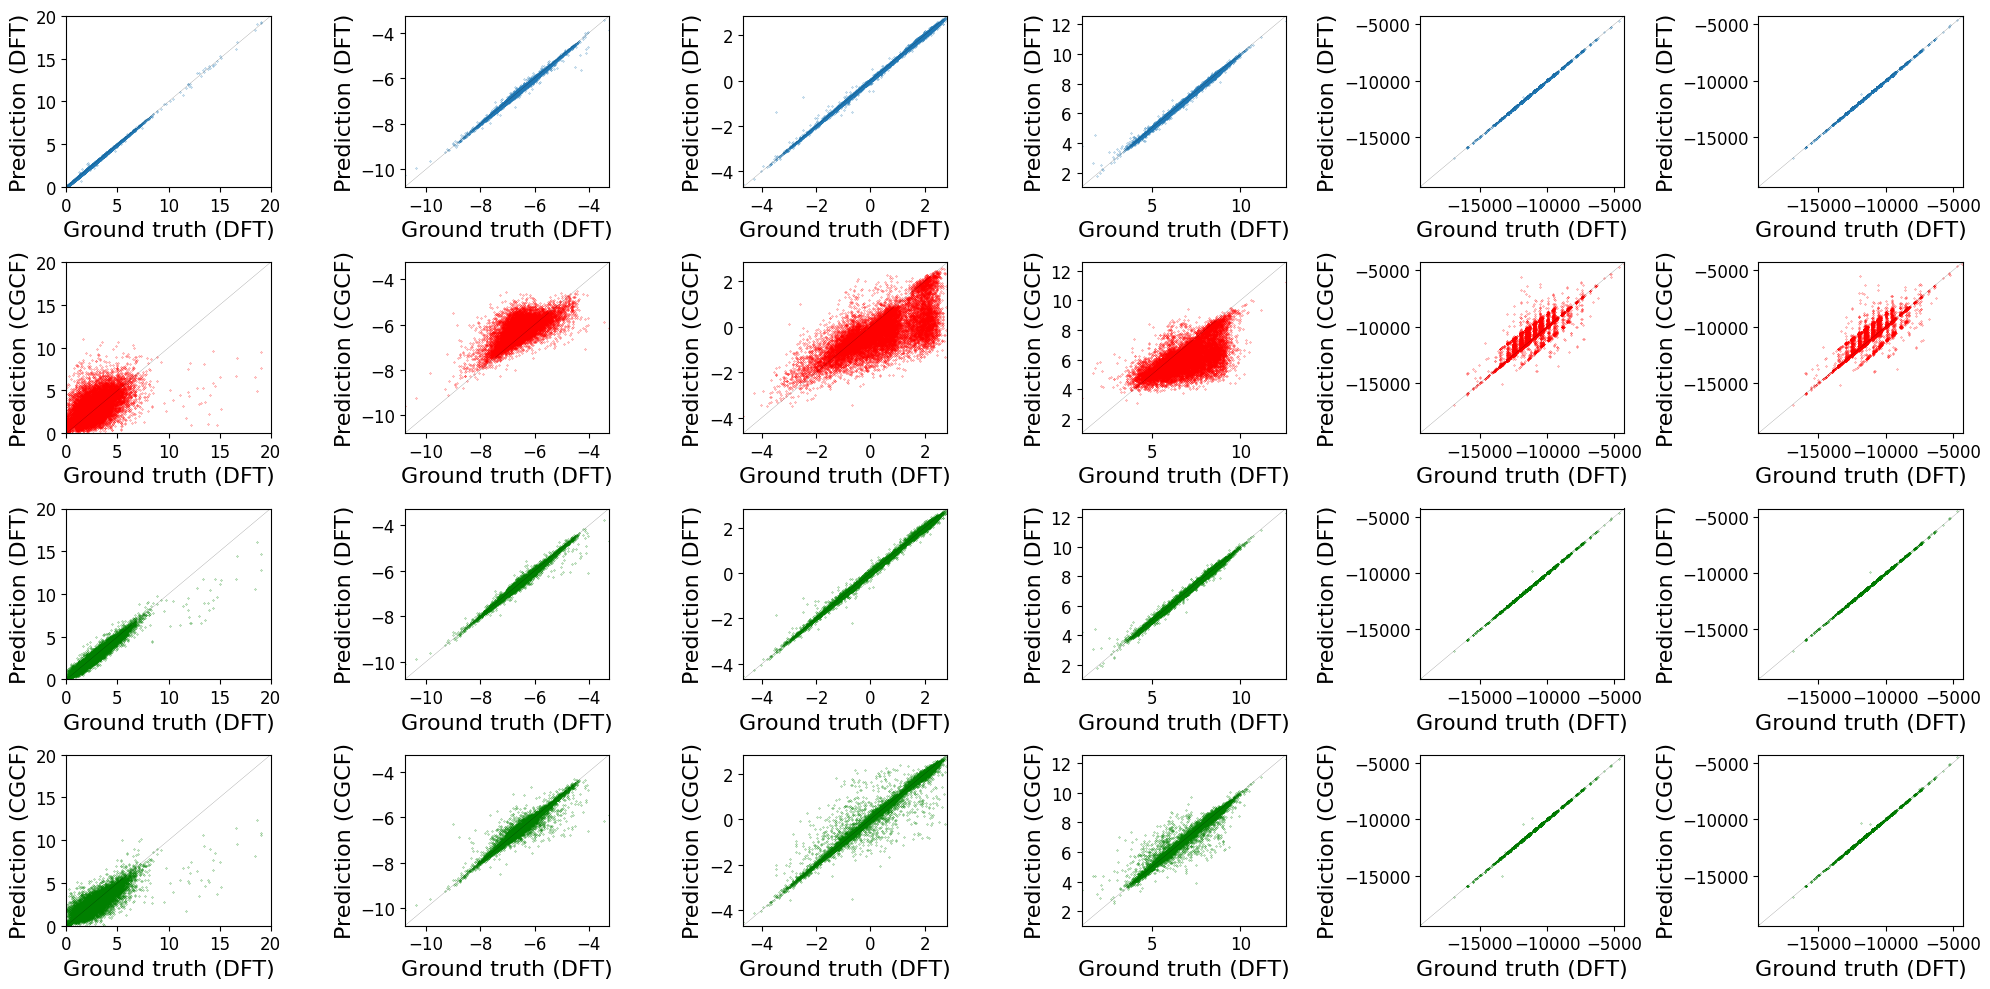

In [19]:
plt.figure(figsize=(20, 10))
fontdict = {'fontsize':16}

lim = 20
ax1 = plt.subplot(4,6,1)
plt.scatter(l_mu, g_g_mu, s=0.05)
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,7)
plt.scatter(l_mu, g_sg_mu, s=0.05, c='red')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,13)
plt.scatter(l_mu, b_g_mu, s=0.05, c='green')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,19)
plt.scatter(l_mu, b_sg_mu, s=0.05, c='green')
plt.plot([0,lim], [0,lim], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(0,lim)
plt.ylim(0,lim)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

ax1 = plt.subplot(4,6,2)
plt.scatter(l_homo, g_g_homo, s=0.05)
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,8)
plt.scatter(l_homo, g_sg_homo, s=0.05, c='red')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,14)
plt.scatter(l_homo, b_g_homo, s=0.05, c='green')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,20)
plt.scatter(l_homo, b_sg_homo, s=0.05, c='green')
plt.plot([min(l_homo), max(l_homo)], [min(l_homo), max(l_homo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_homo), max(l_homo))
plt.ylim(min(l_homo), max(l_homo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,3)
plt.scatter(l_lumo, g_g_lumo, s=0.05)
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,9)
plt.scatter(l_lumo, g_sg_lumo, s=0.05, c='red')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,15)
plt.scatter(l_lumo, b_g_lumo, s=0.05, c='green')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,21)
plt.scatter(l_lumo, b_sg_lumo, s=0.05, c='green')
plt.plot([min(l_lumo), max(l_lumo)], [min(l_lumo), max(l_lumo)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_lumo), max(l_lumo))
plt.ylim(min(l_lumo), max(l_lumo))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,4)
plt.scatter(l_gap, g_g_gap, s=0.05)
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,10)
plt.scatter(l_gap, g_sg_gap, s=0.05, c='red')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,16)
plt.scatter(l_gap, b_g_gap, s=0.05, c='green')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,22)
plt.scatter(l_gap, b_sg_gap, s=0.05, c='green')
plt.plot([min(l_gap), max(l_gap)], [min(l_gap), max(l_gap)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_gap), max(l_gap))
plt.ylim(min(l_gap), max(l_gap))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,5)
plt.scatter(l_U0, g_g_U0, s=0.05)
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,11)
plt.scatter(l_U0, g_sg_U0, s=0.05, c='red')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,17)
plt.scatter(l_U0, b_g_U0, s=0.05, c='green')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,23)
plt.scatter(l_U0, b_sg_U0, s=0.05, c='green')
plt.plot([min(l_U0), max(l_U0)], [min(l_U0), max(l_U0)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_U0), max(l_U0))
plt.ylim(min(l_U0), max(l_U0))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


ax1 = plt.subplot(4,6,6)
plt.scatter(l_G, g_g_G, s=0.05)
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,12)
plt.scatter(l_G, g_sg_G, s=0.05, c='red')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,18)
plt.scatter(l_G, b_g_G, s=0.05, c='green')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (DFT)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax1 = plt.subplot(4,6,24)
plt.scatter(l_G, b_sg_G, s=0.05, c='green')
plt.plot([min(l_G), max(l_G)], [min(l_G), max(l_G)], color = 'black', linewidth=0.1)
plt.xlabel('Ground truth (DFT)', fontdict=fontdict)
plt.ylabel('Prediction (CGCF)', fontdict=fontdict)
plt.xlim(min(l_G), max(l_G))
plt.ylim(min(l_G), max(l_G))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)


plt.tight_layout()

plt.savefig('./figures/parity_plot_cgcf.png', transparent=True, dpi=500)

(tensor(-10.7839), tensor(-3.2545))